In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
import pdb

### Final Results for different setting of hyperparameters and optimizers

#### SGD optimization
| Hidden Nodes | Activation | Train MSE | Test MSE |
|--------------|------------|-----------|----------|
| 25           | Tanh       | 2.8077    | 2.749    |
| 25           | ReLU       | 0.975     | 1.078    |
| 50           | Tanh       | 3.212     | 0.648    |
| 50           | ReLU       | 1.256     | 29.061   |
| 75           | Tanh       | 3.377     | 3.051    |
| 75           | ReLU       | 1.828     | 1.345    |

#### RProp optimization
| Hidden Nodes | Activation | Train MSE | Test MSE |
|--------------|------------|-----------|----------|
| 25           | Tanh       | 0.049     | 0.099    |
| 25           | ReLU       | 0.0711    | 0.0945   |
| 50           | Tanh       | 0.0336    | 1.181    |
| 50           | ReLU       | 0.0501    | 66.626   |
| 75           | Tanh       | 0.0263    | 0.114    |
| 75           | ReLU       | 0.0406    | 0.08     |

#### QuickProp optimization
| Hidden Nodes | Activation | Train MSE | Test MSE    |
|--------------|------------|-----------|-------------|
| 25           | Tanh       | 0.448     | 0.451       |
| 25           | ReLU       | 0.404     | 0.330       |
| 50           | Tanh       | 0.381     | 80.52       |
| 50           | ReLU       | 3312.96   | 45182369.32 |
| 75           | Tanh       | 0.6105    | 0.4178      |
| 75           | ReLU       | 748122    | 6325.7      |

### Read  dataset

In [2]:
path = 'Concrete_Data.xls'
frame = pd.read_excel(path)
frame = frame.to_numpy()
data, labels = frame[:, :-1], frame[:, -1]

data_dev = data.std(axis=0)
data = data - data.mean(axis=0)
data = data / data_dev
labels_dev = labels.std(axis=0)
labels = labels - labels.mean(axis=0)
labels = labels / labels_dev

shuffle_indices = np.random.permutation(data.shape[0])
data = data[shuffle_indices]
labels = labels[shuffle_indices]

test_split = int(data.shape[0] * 0.7)

X_train, y_train = data[0:test_split], labels[0:test_split]
X_test, y_test = data[test_split::], labels[test_split::]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(721, 8) (721,)
(309, 8) (309,)


## 3 Layer network

$y_{pred}= w_{ho}f(w_{ih}X)$

`X` is a augmented feature matrix `x` that includes bias term also.

The loss function used to train this model is MSE. This loss function is defined as:

$L(y_{target}, y_{pred}) = \frac{1}{N}\sum_{i=1}^{N} (y_{target}-y_{pred})^2$



### Gradient Calculation for back propagation

The gradient of the above loss function w.r.t y_pred is :

$\nabla_{y_{pred}} L = -\frac{2}{N}\sum_{i=1}^{N}(y_{target}-y_{pred})$

The parameters of this MLP are $w_ho$ and $w_ih$.The gradients are:

$\nabla_{w_{ho}} L = \nabla_{y_{pred}} L \times \nabla_{w_{ho}} y_{pred}$

$\nabla_{w_{ho}} L = \nabla_{y_{pred}} L \times f(w_{ih}X)$

The gradient of weight $w_ih$ is calculated as follows:

$\nabla_{w_{ih}} L = \nabla_{y_{pred}} L \times \nabla_{f(w_{ih}X)} y_{pred} \times \nabla_{w_{ih}}f(w_{ih}X) $

$\nabla_{w_{ih}} L = \nabla_{y_{pred}} L \times w_{ho} \times f\prime(w_{ih}X)X $


### Different optimization algorithms

Different optimization algorithms are used to update the weights of a network. These update rules are defined below.

- Gradient descent using batch propagation<br>
   $$w^{(k)} = w^{(k-1)}-\eta\nabla_w Loss$$

- Optimization using Rrop algorithm
    $$w^{(k)} = w^{(k-1)}-\eta^{(k-1)}sign(\nabla_{w^{(k-1)}} Loss)$$
    
$$\eta^{(k)} = \left\{
            \begin{array}{ll}
                  min(\eta^{(k-1)}\alpha, \eta_{max}) & sign(\nabla_{w^{(k-1)}} Loss) == sign(\nabla_{w^{(k)}} Loss) \\
                  max(\eta^{(k-1)}\beta, \eta_{min}) & otherwise \\
            \end{array} 
            \right.  $$

- Optimization using QuickProp algorithm
$$ \Delta w^{(k)} = \Delta w^{(k-1)} \frac{\nabla_w^{(k)}Loss}{\nabla_w^{(k-1)}Loss-\nabla_w^{(k)}Loss}$$

     $$ w^{(k)} = w^{(k)} - \Delta  w^{(k)}$$

### Creating MLP and functions

In [42]:
def create_MLP_params(input_dim, hidden_dim, output_dim):
    w_ih = np.random.rand(input_dim + 1, hidden_dim)
    w_ho = np.random.rand(hidden_dim + 1, output_dim)
    return w_ih, w_ho


def tanh(X):
    return np.tanh(X)


def relu(X):
    return np.maximum(X, 0)


def tanh_grad(X):
    return 1 - np.tanh(X)**2


def relu_grad(X):
    g = np.zeros(X.shape)
    g[X > 0] = 1
    return g


def forward_pass(X, w_ih, w_ho, activation):
    z_0 = np.matmul(X, w_ih)
    y_0 = activation(z_0)

    y_0 = np.concatenate([y_0, np.ones((y_0.shape[0], 1))], axis=1)
    y_1 = np.matmul(y_0, w_ho)

    return z_0, y_0, y_1


def loss(y_pred, y):
    y = y.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    N = y.shape[0]
    l_ = ((y-y_pred)**2).sum(axis=0) / N
    l_grad = -2*(y-y_pred) / N
    return l_, l_grad


def backward_pass(X, y_pred, y, z_0, y_0, w_ih, w_ho, activation_grad):
    l, l_grad = loss(y_pred, y)
    z_0_grad = activation_grad(z_0)
    z_0_grad = np.concatenate([z_0_grad, np.zeros((z_0_grad.shape[0], 1))], axis=1)
    w_ho_grad = (l_grad*y_0).sum(axis=0).T
    w_ho_grad = w_ho_grad.reshape(-1, 1)
    w_ih_grad = np.matmul((l_grad * w_ho.T * z_0_grad).T, X).T
    w_ih_grad = w_ih_grad[:, :-1]

    return w_ho_grad, w_ih_grad, l

### SGD optimization

In [119]:
def SGD(X, y, hidden_dim, activation, activation_grad, epochs=1000, lr=0.01):
    input_dim = X.shape[1]
    output_dim = 1
    X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
    
    losses = []

    w_ih, w_ho = create_MLP_params(input_dim, hidden_dim, output_dim)

    counter = 0
    for i in range(epochs):
        z_0, y_0, y_pred = forward_pass(X, w_ih, w_ho, activation)
        w_ho_grad, w_ih_grad, loss_ = backward_pass(X, y_pred, y, z_0, y_0, w_ih, w_ho, activation_grad)
        w_ho -= lr*w_ho_grad
        w_ih -= lr*w_ih_grad

        counter += 1
        losses.append(loss_)
        if counter % 100 == 0:
            print("Epoch: {}, Loss:{}".format(counter, loss_))

    return w_ho, w_ih, losses

Hidden layer size:25, Activation Function:tanh
Epoch: 100, Loss:[19.20434807]
Epoch: 200, Loss:[14.70388187]
Epoch: 300, Loss:[11.44794398]
Epoch: 400, Loss:[9.04242428]
Epoch: 500, Loss:[7.23478879]
Epoch: 600, Loss:[5.85742]
Epoch: 700, Loss:[4.79570649]
Epoch: 800, Loss:[3.96928958]
Epoch: 900, Loss:[3.32061959]
Epoch: 1000, Loss:[2.80773609]


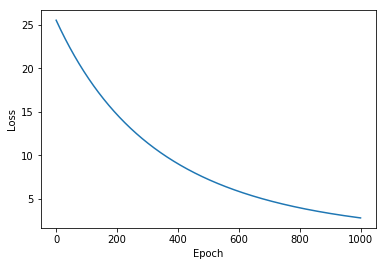

Hidden layer size:25, Activation Function:relu
Epoch: 100, Loss:[32.71868716]
Epoch: 200, Loss:[13.96441745]
Epoch: 300, Loss:[6.53041551]
Epoch: 400, Loss:[3.42276284]
Epoch: 500, Loss:[2.0861998]
Epoch: 600, Loss:[1.49616815]
Epoch: 700, Loss:[1.22556223]
Epoch: 800, Loss:[1.09290044]
Epoch: 900, Loss:[1.02056536]
Epoch: 1000, Loss:[0.97522153]


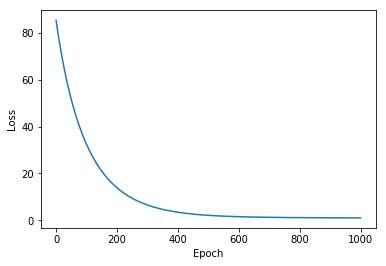

Hidden layer size:50, Activation Function:tanh
Epoch: 100, Loss:[56.92346103]
Epoch: 200, Loss:[37.08251602]
Epoch: 300, Loss:[25.10507885]
Epoch: 400, Loss:[17.51568907]
Epoch: 500, Loss:[12.5301913]
Epoch: 600, Loss:[9.16409275]
Epoch: 700, Loss:[6.84197191]
Epoch: 800, Loss:[5.21183836]
Epoch: 900, Loss:[4.0504978]
Epoch: 1000, Loss:[3.21234567]


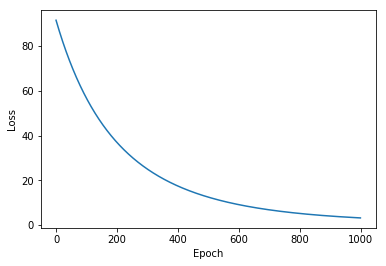

Hidden layer size:50, Activation Function:relu
Epoch: 100, Loss:[95.57989827]
Epoch: 200, Loss:[22.79942042]
Epoch: 300, Loss:[6.95958891]
Epoch: 400, Loss:[3.11984768]
Epoch: 500, Loss:[2.07123831]
Epoch: 600, Loss:[1.70807321]
Epoch: 700, Loss:[1.53036919]
Epoch: 800, Loss:[1.41454864]
Epoch: 900, Loss:[1.32683829]
Epoch: 1000, Loss:[1.2560856]


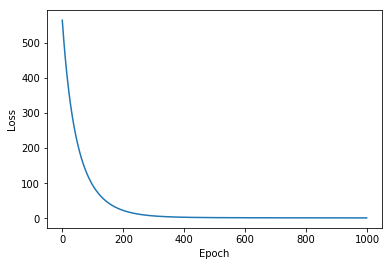

Hidden layer size:75, Activation Function:tanh
Epoch: 100, Loss:[143.53152403]
Epoch: 200, Loss:[70.23097613]
Epoch: 300, Loss:[38.05714872]
Epoch: 400, Loss:[22.36267683]
Epoch: 500, Loss:[14.12622859]
Epoch: 600, Loss:[9.54253129]
Epoch: 700, Loss:[6.85256772]
Epoch: 800, Loss:[5.1910275]
Epoch: 900, Loss:[4.11220343]
Epoch: 1000, Loss:[3.37766194]


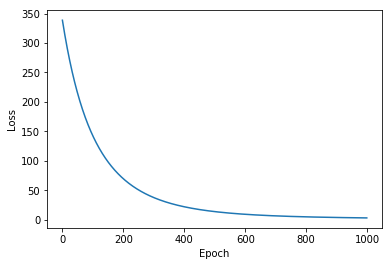

Hidden layer size:75, Activation Function:relu
Epoch: 100, Loss:[105.50948091]
Epoch: 200, Loss:[16.45788392]
Epoch: 300, Loss:[5.35707742]
Epoch: 400, Loss:[3.46127445]
Epoch: 500, Loss:[2.85560135]
Epoch: 600, Loss:[2.51590868]
Epoch: 700, Loss:[2.27613048]
Epoch: 800, Loss:[2.09253394]
Epoch: 900, Loss:[1.94696722]
Epoch: 1000, Loss:[1.82869214]


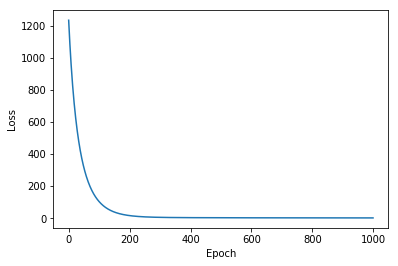

In [120]:
SGD_weights = []
for hidden_dim in [25, 50, 75]:
    for activation, activation_grad in [(tanh, tanh_grad), (relu, relu_grad)]:
        print("Hidden layer size:{}, Activation Function:{}".format(hidden_dim, activation.__name__))
        w_ho, w_ih, losses = SGD(X_train, y_train, hidden_dim, activation, activation_grad, epochs=1000, lr=1e-4)
        SGD_weights.append((w_ho, w_ih))
        plt.plot(losses, label="Loss vs Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

### RProp Optimization

In [117]:
def RProp(X, y, hidden_dim, activation, activation_grad, epochs=1000, lr=0.01):
    input_dim = X.shape[1]
    output_dim = 1
    X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
    
    losses = []

    w_ih, w_ho = create_MLP_params(input_dim, hidden_dim, output_dim)

    lr_min = -np.inf
    lr_max = np.inf
    alpha = 1.2
    beta = 0.5
    lr_w_ih = np.ones(w_ih.shape)*0.01
    lr_w_ho = np.ones(w_ho.shape)*0.01

    counter = 0
    for i in range(epochs):
        z_0, y_0, y_pred = forward_pass(X, w_ih, w_ho, activation)
        w_ho_grad, w_ih_grad, loss_ = backward_pass(X, y_pred, y, z_0, y_0, w_ih, w_ho, activation_grad)
        w_ho -= lr_w_ho*np.sign(w_ho_grad)
        w_ih -= lr_w_ih*np.sign(w_ih_grad)

        if counter >= 1:
            t = np.sign(prev_w_ho_grad)*np.sign(w_ho_grad)
            same_sign_pos = np.where(t > 0)
            opp_sign_pos = np.where(t <= 0)
            lr_w_ho[same_sign_pos] = np.minimum(lr_w_ho[same_sign_pos]*alpha, lr_max)
            lr_w_ho[opp_sign_pos] = np.maximum(lr_w_ho[opp_sign_pos]*beta, lr_min)

            t = np.sign(prev_w_ih_grad)*np.sign(w_ih_grad)
            same_sign_pos = np.where(t > 0)
            opp_sign_pos = np.where(t <= 0)
            lr_w_ih[same_sign_pos] = np.minimum(lr_w_ih[same_sign_pos]*alpha, lr_max)
            lr_w_ih[opp_sign_pos] = np.maximum(lr_w_ih[opp_sign_pos]*beta, lr_min)

        prev_w_ho_grad = w_ho_grad
        prev_w_ih_grad = w_ih_grad

        counter += 1
        losses.append(loss_)
        if counter % 100 == 0:
            print("Epoch: {}, Loss:{}".format(counter, loss_))

    return w_ho, w_ih, losses


Hidden layer size:25, Activation Function:tanh
Epoch: 100, Loss:[0.11043852]
Epoch: 200, Loss:[0.08277547]
Epoch: 300, Loss:[0.07169967]
Epoch: 400, Loss:[0.06627775]
Epoch: 500, Loss:[0.06210427]
Epoch: 600, Loss:[0.05895405]
Epoch: 700, Loss:[0.05676662]
Epoch: 800, Loss:[0.05467747]
Epoch: 900, Loss:[0.05223822]
Epoch: 1000, Loss:[0.04941748]


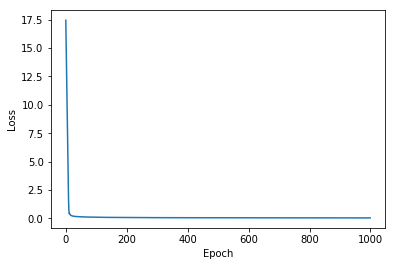

Hidden layer size:25, Activation Function:relu
Epoch: 100, Loss:[0.12231814]
Epoch: 200, Loss:[0.10469696]
Epoch: 300, Loss:[0.09488302]
Epoch: 400, Loss:[0.08904004]
Epoch: 500, Loss:[0.08460077]
Epoch: 600, Loss:[0.08146374]
Epoch: 700, Loss:[0.07821582]
Epoch: 800, Loss:[0.07485685]
Epoch: 900, Loss:[0.07250716]
Epoch: 1000, Loss:[0.0711548]


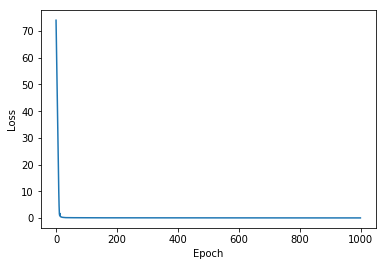

Hidden layer size:50, Activation Function:tanh
Epoch: 100, Loss:[0.10921514]
Epoch: 200, Loss:[0.07624453]
Epoch: 300, Loss:[0.06145436]
Epoch: 400, Loss:[0.05328121]
Epoch: 500, Loss:[0.0467249]
Epoch: 600, Loss:[0.04273329]
Epoch: 700, Loss:[0.03956747]
Epoch: 800, Loss:[0.03720001]
Epoch: 900, Loss:[0.03516695]
Epoch: 1000, Loss:[0.03360672]


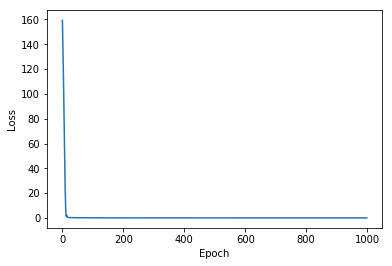

Hidden layer size:50, Activation Function:relu
Epoch: 100, Loss:[0.12122927]
Epoch: 200, Loss:[0.08966398]
Epoch: 300, Loss:[0.07611994]
Epoch: 400, Loss:[0.0674541]
Epoch: 500, Loss:[0.06266999]
Epoch: 600, Loss:[0.05866198]
Epoch: 700, Loss:[0.0553452]
Epoch: 800, Loss:[0.05324508]
Epoch: 900, Loss:[0.05155263]
Epoch: 1000, Loss:[0.05011693]


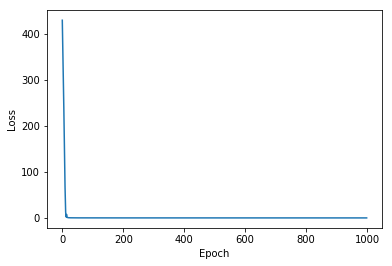

Hidden layer size:75, Activation Function:tanh
Epoch: 100, Loss:[0.08967959]
Epoch: 200, Loss:[0.06016739]
Epoch: 300, Loss:[0.04850683]
Epoch: 400, Loss:[0.04201715]
Epoch: 500, Loss:[0.03705651]
Epoch: 600, Loss:[0.03373535]
Epoch: 700, Loss:[0.03076168]
Epoch: 800, Loss:[0.02881828]
Epoch: 900, Loss:[0.02742941]
Epoch: 1000, Loss:[0.02630356]


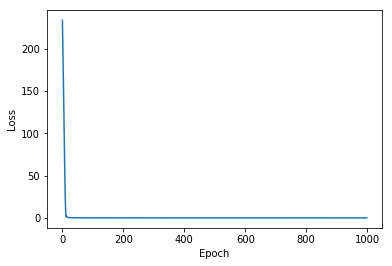

Hidden layer size:75, Activation Function:relu
Epoch: 100, Loss:[0.1022025]
Epoch: 200, Loss:[0.0783746]
Epoch: 300, Loss:[0.06431504]
Epoch: 400, Loss:[0.05626243]
Epoch: 500, Loss:[0.05145388]
Epoch: 600, Loss:[0.04863226]
Epoch: 700, Loss:[0.0460421]
Epoch: 800, Loss:[0.04392517]
Epoch: 900, Loss:[0.04215403]
Epoch: 1000, Loss:[0.04064898]


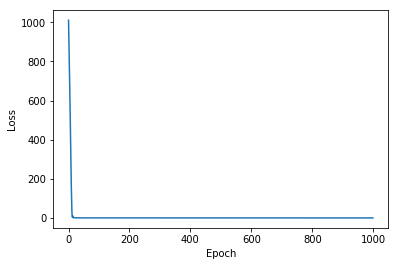

In [118]:
RProp_weights = []
for hidden_dim in [25, 50, 75]:
    for activation, activation_grad in [(tanh, tanh_grad), (relu, relu_grad)]:
        print("Hidden layer size:{}, Activation Function:{}".format(hidden_dim, activation.__name__))
        w_ho, w_ih, losses = RProp(X_train, y_train, hidden_dim, activation, activation_grad, epochs=1000, lr=1e-4)
        RProp_weights.append((w_ho, w_ih))
        plt.plot(losses, label="Loss vs Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

### QuickProp optimization

In [114]:
def QProp(X, y, hidden_dim, activation, activation_grad, epochs=1000, lr=0.01):
    input_dim = X.shape[1]
    output_dim = 1
    X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
    
    losses = []

    w_ih, w_ho = create_MLP_params(input_dim, hidden_dim, output_dim)

    delta_w_ih = np.ones(w_ih.shape)*0.01
    delta_w_ho = np.ones(w_ho.shape)*0.01

    counter = 0
    for i in range(epochs):
        z_0, y_0, y_pred = forward_pass(X, w_ih, w_ho, activation)
        w_ho_grad, w_ih_grad, loss_ = backward_pass(X, y_pred, y, z_0, y_0, w_ih, w_ho, activation_grad)
        
        if counter >= 1:
#             assert ((prev_w_ho_grad-w_ho_grad)!=0).all()
#             assert ((prev_w_ih_grad-w_ih_grad)!=0).all()
            delta_w_ho = delta_w_ho*(w_ho_grad/(prev_w_ho_grad - w_ho_grad + 1e-10))
            delta_w_ih = delta_w_ih*(w_ih_grad/(prev_w_ih_grad- w_ih_grad + 1e-10))

        w_ho -= delta_w_ho
        w_ih -= delta_w_ih
        prev_w_ho_grad = w_ho_grad.copy()
        prev_w_ih_grad = w_ih_grad.copy()

        counter += 1
        losses.append(loss_)
        if counter % 100 == 0:
            print("Epoch: {}, Loss:{}".format(counter, loss_))

    return w_ho, w_ih, losses


Hidden layer size:25, Activation Function:tanh
Epoch: 100, Loss:[3.16212193]
Epoch: 200, Loss:[0.73913967]
Epoch: 300, Loss:[0.56912694]
Epoch: 400, Loss:[0.53011763]
Epoch: 500, Loss:[0.44182928]
Epoch: 600, Loss:[0.45240768]
Epoch: 700, Loss:[0.45430372]
Epoch: 800, Loss:[0.4500693]
Epoch: 900, Loss:[0.45147495]
Epoch: 1000, Loss:[0.44835854]


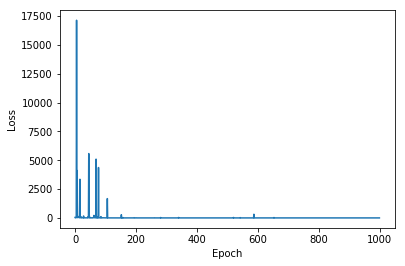

Hidden layer size:25, Activation Function:relu
Epoch: 100, Loss:[1.87180488]
Epoch: 200, Loss:[19.85227851]
Epoch: 300, Loss:[23.04764964]
Epoch: 400, Loss:[0.67656212]
Epoch: 500, Loss:[0.652615]
Epoch: 600, Loss:[0.64454548]
Epoch: 700, Loss:[0.43824321]
Epoch: 800, Loss:[0.35238869]
Epoch: 900, Loss:[0.31365688]
Epoch: 1000, Loss:[0.40457526]


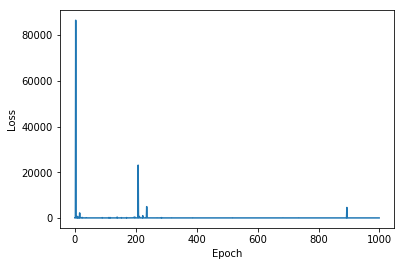

Hidden layer size:50, Activation Function:tanh
Epoch: 100, Loss:[3.09628915]
Epoch: 200, Loss:[4.22164481]
Epoch: 300, Loss:[0.68387486]
Epoch: 400, Loss:[0.45258946]
Epoch: 500, Loss:[0.39674926]
Epoch: 600, Loss:[0.35065289]
Epoch: 700, Loss:[0.36327238]
Epoch: 800, Loss:[0.53775465]
Epoch: 900, Loss:[0.41550473]
Epoch: 1000, Loss:[0.38198376]


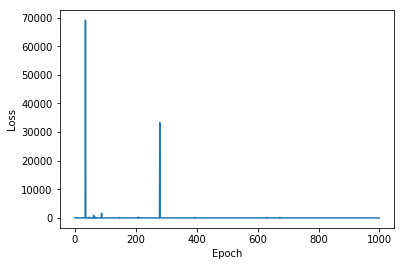

Hidden layer size:50, Activation Function:relu
Epoch: 100, Loss:[125701.02115237]
Epoch: 200, Loss:[37810.41541957]
Epoch: 300, Loss:[19272.43760915]
Epoch: 400, Loss:[11919.10197811]
Epoch: 500, Loss:[7846.40580299]
Epoch: 600, Loss:[5814.87535084]
Epoch: 700, Loss:[5179.09606118]
Epoch: 800, Loss:[9804.68024505]
Epoch: 900, Loss:[4165.95645841]
Epoch: 1000, Loss:[3312.96548348]


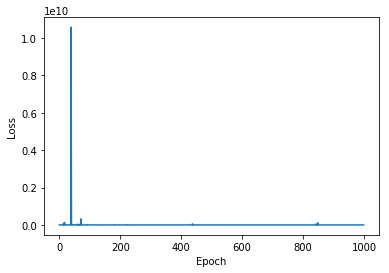

Hidden layer size:75, Activation Function:tanh
Epoch: 100, Loss:[3.19238218]
Epoch: 200, Loss:[63.70006664]
Epoch: 300, Loss:[1170.72545353]
Epoch: 400, Loss:[3.73404465]
Epoch: 500, Loss:[1.59050348]
Epoch: 600, Loss:[139.15435224]
Epoch: 700, Loss:[0.93208633]
Epoch: 800, Loss:[0.82583412]
Epoch: 900, Loss:[9.99031999]
Epoch: 1000, Loss:[0.61054588]


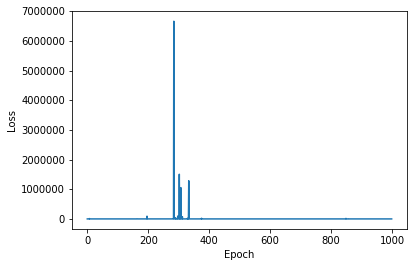

Hidden layer size:75, Activation Function:relu
Epoch: 100, Loss:[60634776.57483787]
Epoch: 200, Loss:[20479435.20406338]
Epoch: 300, Loss:[3031070.40915675]
Epoch: 400, Loss:[3865866.26903254]
Epoch: 500, Loss:[1564036.11318693]
Epoch: 600, Loss:[3593737.63552211]
Epoch: 700, Loss:[1335752.16529236]
Epoch: 800, Loss:[1082227.0383361]
Epoch: 900, Loss:[917789.10501953]
Epoch: 1000, Loss:[748122.34876224]


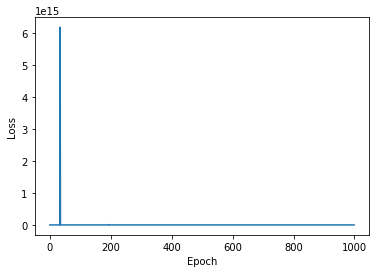

In [115]:
QProp_weights = []
for hidden_dim in [25, 50, 75]:
    for activation, activation_grad in [(tanh, tanh_grad), (relu, relu_grad)]:
        print("Hidden layer size:{}, Activation Function:{}".format(hidden_dim, activation.__name__))
        w_ho, w_ih, losses = QProp(X_train, y_train, hidden_dim, activation, activation_grad, epochs=1000, lr=1e-4)
        QProp_weights.append((w_ho, w_ih))
        plt.plot(losses, label="Loss vs Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

### Observations

- RProp performs better than SGD for the same activation functions and hidden dimensions
- Number of hidden nodes have an arbitrary relation with MSE.
- QuickProp optimisation is unstable, with arbitrary jumps in between.
- ReLU performs better than Tanh when all other settings remain the same.

In [131]:
X = np.concatenate([X_test, np.ones((X_test.shape[0], 1))], axis=1)
for i, hidden_dim in enumerate([25, 50, 75]):
    for j, (activation, activation_grad) in enumerate([(tanh, tanh_grad), (relu, relu_grad)]):
        w_ho, w_ih = SGD_weights[i+j]
        _, _, y_pred = forward_pass(X, w_ih, w_ho, activation)
        loss_, _ = loss(y_pred, y_test)
        print("SGD: Hidden layer size:{}, Activation Function:{}, Loss:{}".format(hidden_dim, activation.__name__, loss_))
        

SGD: Hidden layer size:25, Activation Function:tanh, Loss:[2.74926059]
SGD: Hidden layer size:25, Activation Function:relu, Loss:[1.07896452]
SGD: Hidden layer size:50, Activation Function:tanh, Loss:[0.64867882]
SGD: Hidden layer size:50, Activation Function:relu, Loss:[29.06185448]
SGD: Hidden layer size:75, Activation Function:tanh, Loss:[3.05167959]
SGD: Hidden layer size:75, Activation Function:relu, Loss:[1.34543827]


In [132]:
X = np.concatenate([X_test, np.ones((X_test.shape[0], 1))], axis=1)
for i, hidden_dim in enumerate([25, 50, 75]):
    for j, (activation, activation_grad) in enumerate([(tanh, tanh_grad), (relu, relu_grad)]):
        w_ho, w_ih = RProp_weights[i+j]
        _, _, y_pred = forward_pass(X, w_ih, w_ho, activation)
        loss_, _ = loss(y_pred, y_test)
        print("RProp: Hidden layer size:{}, Activation Function:{}, Loss:{}".format(hidden_dim, activation.__name__, loss_))
        

RProp: Hidden layer size:25, Activation Function:tanh, Loss:[0.09961039]
RProp: Hidden layer size:25, Activation Function:relu, Loss:[0.09450551]
RProp: Hidden layer size:50, Activation Function:tanh, Loss:[1.18165753]
RProp: Hidden layer size:50, Activation Function:relu, Loss:[66.62661749]
RProp: Hidden layer size:75, Activation Function:tanh, Loss:[0.1141462]
RProp: Hidden layer size:75, Activation Function:relu, Loss:[0.0807709]


In [133]:
X = np.concatenate([X_test, np.ones((X_test.shape[0], 1))], axis=1)
for i, hidden_dim in enumerate([25, 50, 75]):
    for j, (activation, activation_grad) in enumerate([(tanh, tanh_grad), (relu, relu_grad)]):
        w_ho, w_ih = QProp_weights[i+j]
        _, _, y_pred = forward_pass(X, w_ih, w_ho, activation)
        loss_, _ = loss(y_pred, y_test)
        print("QuickProp: Hidden layer size:{}, Activation Function:{}, Loss:{}".format(hidden_dim, activation.__name__, loss_))
        

QuickProp: Hidden layer size:25, Activation Function:tanh, Loss:[0.4510277]
QuickProp: Hidden layer size:25, Activation Function:relu, Loss:[0.33006749]
QuickProp: Hidden layer size:50, Activation Function:tanh, Loss:[80.50274552]
QuickProp: Hidden layer size:50, Activation Function:relu, Loss:[45182369.32056198]
QuickProp: Hidden layer size:75, Activation Function:tanh, Loss:[0.4178972]
QuickProp: Hidden layer size:75, Activation Function:relu, Loss:[6325.70414648]
